In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os
import random
import pathlib
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [20]:
from unet.data import loader

In [21]:
root = '/data/idcard/combined/1609935833'
trainloader, trainset = loader.pair_data_loader(root_path=root, mode='train', batch_size=24)
validloader, validset = loader.pair_data_loader(root_path=root, mode='valid', batch_size=24)

In [22]:
from unet.models.unet import UNet
from unet.trainer.task import TaskUNet

model = UNet(in_chan=1, n_classes=1, start_feat=32)
model_state_dict = torch.load('weights/unet_sfeat32.pth')
model.load_state_dict(model_state_dict)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
task = TaskUNet(model, optimizer, criterion)

In [23]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

# DEFAULTS used by the Trainer
SAVED_CHECKPOINT_PATH = 'checkpoints/'
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=SAVED_CHECKPOINT_PATH,
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix='ocrnet'
)

SAVED_LOGS_PATH = 'logs/'
tb_logger = pl_loggers.TensorBoardLogger(SAVED_LOGS_PATH)

trainer = pl.Trainer(
    weights_summary="top",
    max_epochs=100,
    val_check_interval=500,
    gpus=1,
    logger=tb_logger, 
    checkpoint_callback=checkpoint_callback, 
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [24]:
trainer.fit(task, trainloader, validloader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | UNet              | 3 M   
1 | criterion | BCEWithLogitsLoss | 0     
/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Epoch 0: val_loss reached 0.00603 (best 0.00603), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 0: val_loss reached 0.00595 (best 0.00595), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v8.ckpt as top 1


Epoch 1: val_loss reached 0.00594 (best 0.00594), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 1: val_loss reached 0.00593 (best 0.00593), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v8.ckpt as top 1


Epoch 2: val_loss reached 0.00592 (best 0.00592), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 2: val_loss was not in top 1
/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 3: val_loss was not in top 1


1

In [ ]:
state_dict = task.model.state_dict()
unet_path = 'weights/unet_sfeat32.pth'
torch.save(state_dict, unet_path)

In [25]:
unet_path = 'weights/unet_sfeat32.pth'
state_dict = torch.load(unet_path)
model = UNet(in_chan=1, n_classes=1, start_feat=32)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [28]:
imgs, mask = next(iter(validloader))
output = task.model(imgs)
output = torch.sigmoid(output)
output.shape

torch.Size([24, 1, 256, 256])

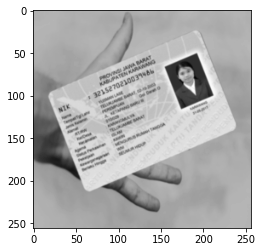

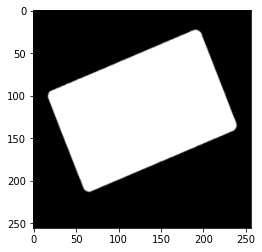

In [30]:
idx = 12
plt.imshow(imgs[idx].squeeze(), cmap='gray');plt.show()
plt.imshow(output[idx].squeeze().cpu().detach().numpy(), cmap='gray')

In [174]:
from unet.prod import Segmentation
unet_path = 'weights/unet_sfeat32.pth'
segment = Segmentation(weight=unet_path)

In [192]:
# im_path = '/data/idcard/combined/1609935833/182_image.jpg'
# im_path = '/data/idcard/fandi_ktp/ktp4.jpg'
im_path = '/data/idcard/ktp_aan/ktp8.jpg'
image,mask,combined = segment.predict(im_path)

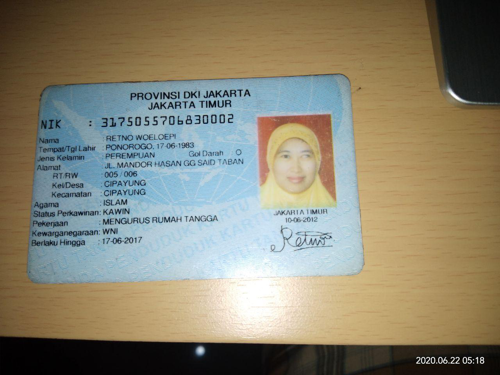

In [193]:
image.resize(size=(1000//2,750//2))

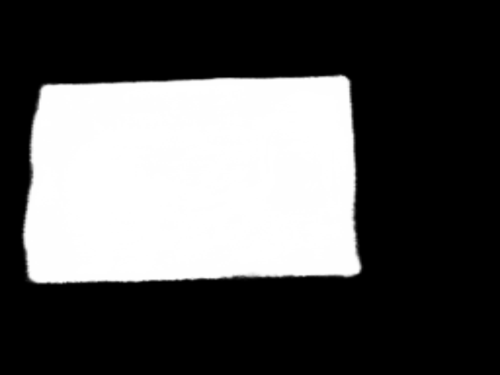

In [194]:
mask.resize(size=(1000//2,750//2))

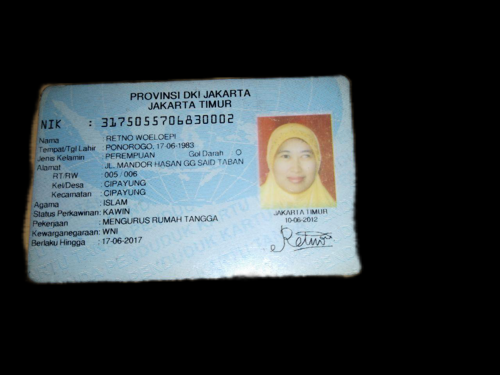

In [195]:
combined.resize(size=(1000//2,750//2))

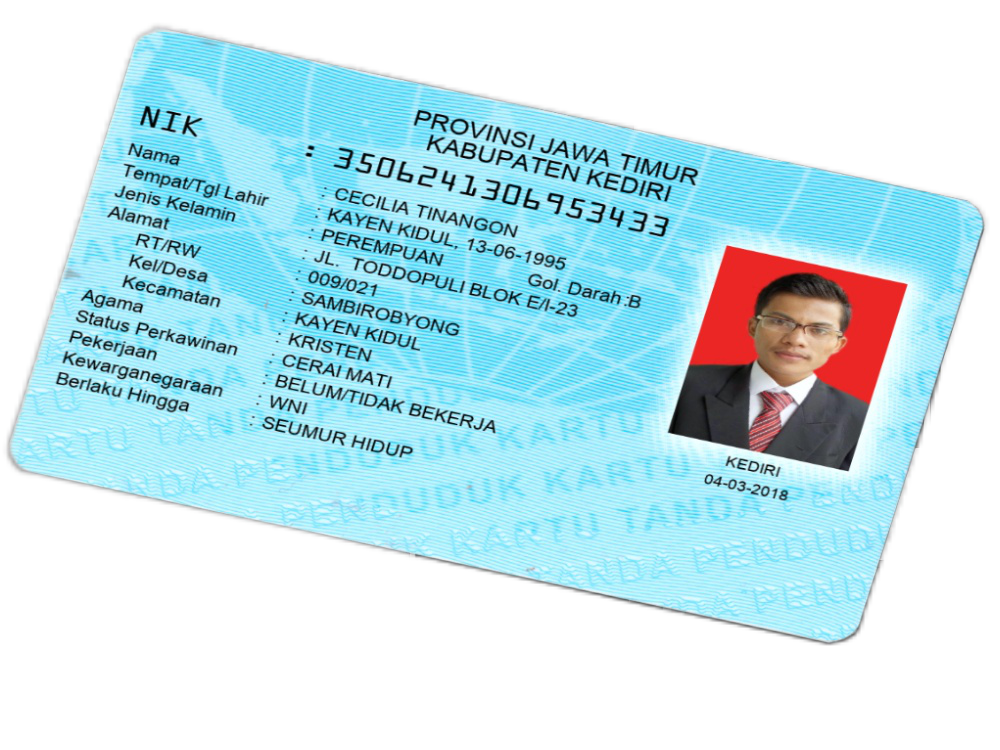

In [173]:
combined

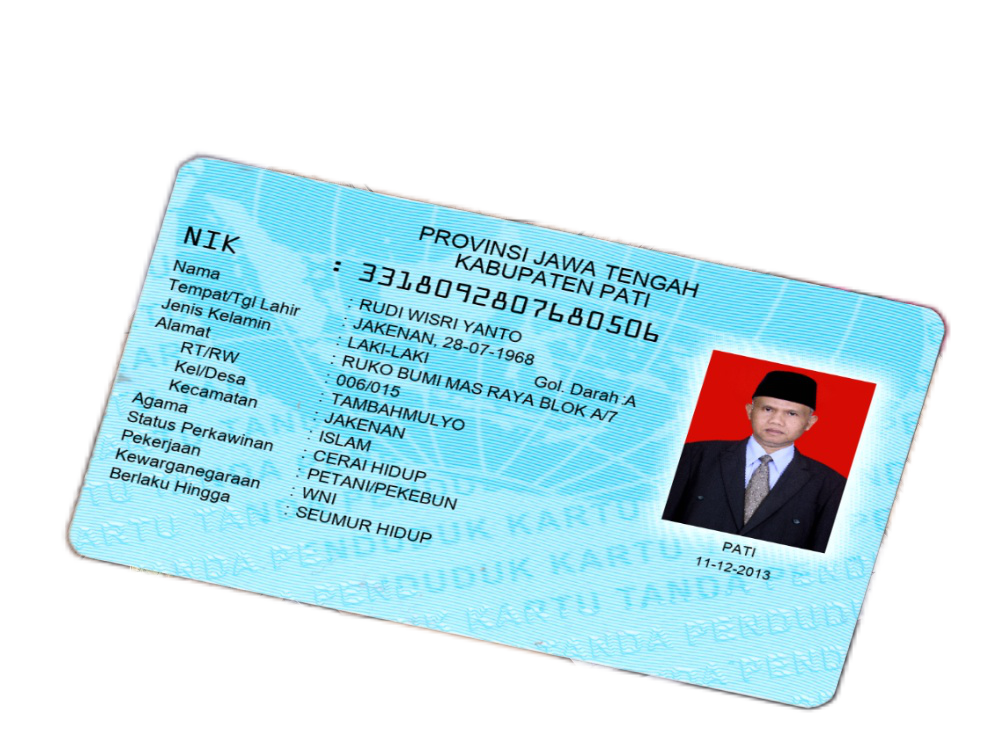

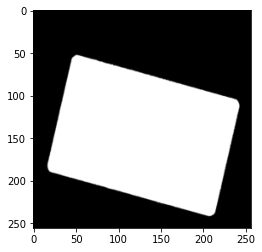

In [76]:
plt.imshow(output, cmap='gray');plt.show()